# JHU covid-19 data analysis
Create log plots of cases and deaths per country, inspired by:  https://www.ft.com/coronavirus-latest 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates  
import numpy as np
from datetime import timedelta
from matplotlib.dates import date2num       #-->Update 

import JHUprocessing as jp

# general parameters

In [2]:
full_w = (12,7)
half_w = (6,4)

# import and merge data

In [3]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_time_series'
file_list = ['\\time_series_covid19_confirmed_global.csv',
         '\\time_series_covid19_deaths_global.csv',
         '\\time_series_covid19_recovered_global.csv'] 

df_country = jp.merge_data(path, file_list) 

# remove diamond princess 

In [4]:
bool_other = df_country['Country/Region'].str.contains( 'Princess' , regex=False)

print('df_US shape: ' , df_country.shape)
df_country.drop( df_country[bool_other].index, inplace=True) 
print('df_US shape: ' , df_country.shape)

df_US shape:  (12600, 5)
df_US shape:  (12530, 5)


# add column with day since 100 cases 

In [5]:
threshold_cases = 1e2
threshold_deaths = 25

last_day = df_country['Date'].max()
bool_last = df_country['Date'] == last_day
df_country.loc[bool_last,'Confirmed']  > threshold_cases 
countries = df_country['Country/Region'].unique() 
threshold_countries = []

for country in countries: 
    bool_country = df_country['Country/Region'] == country  
    df_temp = df_country[bool_country].copy()
    
    bool_threshold_cases = df_temp['Confirmed'] >= threshold_cases
    if bool_threshold_cases.sum() > 0: 
        day0 = df_temp.loc[bool_threshold_cases,'Date'].iloc[0]
        threshold_countries.append(country) 
    else: 
        day0 = last_day + timedelta(days=1) 

    newdays = (df_temp['Date'] - day0).dt.days  
    
    df_country.loc[bool_country,'Delta C'] = newdays
     
    
    bool_threshold_death = df_temp['Death'] >= threshold_deaths
    if bool_threshold_death.sum() > 0:
        day0 = df_temp['Date'][bool_threshold_death].iloc[0]
    else:
        day0 = last_day + timedelta(days=1) 
        
    newdays = (df_temp['Date'] - day0).dt.days 
    df_country.loc[bool_country,'Delta D'] = newdays 
    
    
    

# correct china days for plotting 

In [11]:

bool_nochina = df_country['Country/Region']!= 'China'
xCmax = df_country.loc[bool_nochina,'Delta C'].max()
xDmax = df_country.loc[bool_nochina,'Delta D'].max()
 
china_add = 7
last_day = df_country['Date'].unique()[-1] 

# bool_last = df_country['Date'] == last_day 
bool_cases= df_country['Delta C'] > (xCmax+china_add)
bool_deaths = df_country['Delta D'] > (xDmax+china_add)
bool_china = df_country['Country/Region'] == 'China'

# df_country.loc[bool_cases & bool_china,'Delta C'] = 47

df_country.loc[bool_cases & bool_china,'Delta C'] = xCmax+5
df_country.loc[bool_deaths & bool_china,'Delta D'] = xDmax+5
 

# features to add:
- color for doubling rate
- ylim as function of max
- china sign to show continuation
- font 
- more ticks 

In [8]:
# find doubling rate, average over last 3 days? 

average_period = 4

last_day = df_country['Date'].max() #- timedelta(days=3)
prior_day = df_country['Date'].max() - timedelta(days=average_period)

bool_last = df_country['Date'] == last_day
bool_prior = df_country['Date'] == prior_day
 
# df_ratio = df_country[bool_last].copy().reset_index(drop=True)
for country in countries: 
    bool_country = df_country['Country/Region'] == country   
    
    ratio = df_country.loc[bool_last & bool_country,'Confirmed'].values[0]  / \
            df_country.loc[bool_prior & bool_country,'Confirmed'].values[0]  
#     print(ratio) 
    
    daily_ratio = ratio**(1/average_period) 
#     print(daily_ratio) 
    
    df_country.loc[bool_country,'ratio'] = daily_ratio
    
#     bool_c = df_ratio['Country/Region'] == country 
#     df_ratio.loc[bool_c,'ratio'] = daily_ratio
    
#     df_country[bool_prior & bool_country]

D:\D_program_files\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in longlong_scalars
  app.launch_new_instance()


In [9]:
 
bin_array = np.array( [0, 2.**(1./20), 2.**(1./15), 2.**(1./10), 2.**(1./7), 2.**(1./5)  ,np.inf ]) 
df_country['doubling'] = pd.cut( df_country['ratio'],   bin_array ,labels=range(len(bin_array)-1) , include_lowest=True )
 
    
df_country['doubling'].unique()

[4, 2, 5, 3, 0, 1]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

# Plot countries

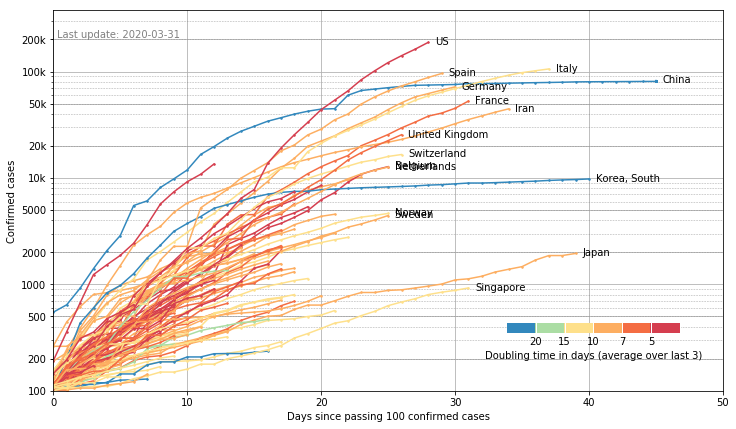

In [34]:
cols = np.array([[213,62,79],
[244,109,67],
[253,174,97],
[254,224,139],
# [230,245,152],
[171,221,164],
# [102,194,165],
[50,136,189]]) /255 
cols = np.flipud(cols)

fig, ax = plt.subplots(1,1 ,figsize= full_w )
cmap = plt.cm.jet  # define the colormap
for country in threshold_countries:
    bool_country = df_country['Country/Region'] == country 
    df_pl = df_country[bool_country] 
    doubling_category = df_pl['doubling'].iloc[0]
    pl1 = ax.plot( df_pl['Delta C' ],  df_pl['Confirmed'],
            '.-' ,ms=3,lw=1.5, label=country,
               color = cols[doubling_category])
     
    df_pl['doubling']
    y = df_pl['Confirmed'].iloc[-1]*0.95
    x = df_pl['Delta C'].iloc[-1] + 0.5
    if x > 25:
        ax.annotate( country ,[x,y])
    
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.grid(True,which="minor", linestyle=':', color=[.5,.5,.5],linewidth=0.6)  
# ax.set_title('Number of Cases in top countries (last update: ' + str( df_country['Date'].iloc[-1]) + ')' ) 
# ax.set_xlim([0,70])

ymax = df_country['Confirmed'].max()
# ymax = df_country['Delta C'].max()

ax.yaxis.set_ticks([1e2,2e2,5e2,1e3,2e3,5e3,1e4,2e4,5e4,1e5,2e5,5e5,1e6,2e6,5e6,])
ax.yaxis.set_ticklabels([100,200,500, 1000,2000,5000, '10k','20k','50k', '100k','200k','500k','1m','2m','5m'])

ax.set_xlim([0,xCmax+10])
ax.set_ylim([100,ymax*2])

ax.set_xlabel("Days since passing 100 confirmed cases") 
ax.set_ylabel("Confirmed cases") 

ax.annotate('Last update: '+str( df_country['Date'].iloc[-1]), 
            [.3,round(ymax,5)*1.1], color=[.5,.5,.5])

from matplotlib.colors import ListedColormap
 

cmap = ListedColormap(cols)
xy = []
sc = plt.scatter(xy, xy, c=xy, vmin=0, vmax=1, cmap=cmap)
cax = fig.add_axes([0.65, 0.24, 0.2, 0.02])
cb = plt.colorbar(sc, cax = cax, orientation='horizontal') 

cb.set_ticks(np.linspace(1/6,1,6)) 
cb.set_ticklabels( ['20','15','10','7','5']) 
cb.set_label('Doubling time in days (average over last 3)')
cb.outline.set_visible(False)

cb.ax.tick_params(which='major', length=15, width=1, direction='in',color='w')


# # # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_country_caseslog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            ) 

# plot deaths 

In [ ]:
fig, ax = plt.subplots(1,1 ,figsize=full_w )

for country in threshold_countries:
    bool_country = df_country['Country/Region'] == country 
    df_pl = df_country[bool_country] 
    ax.plot( df_pl['Delta D' ],  df_pl['Death'],'.-' ,ms=3,lw=1.5, label=country )
     
    y = df_pl['Death'].iloc[-1]*0.95
    x = df_pl['Delta D'].iloc[-1] + 0.5
    if x > 20:
        ax.annotate( country ,[x,y])
    
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.set_title('Number of Deaths in top countries (last update: ' + str(df_country['Date'].iloc[-1]) + ')' ) 
ax.set_xlim([0,50])
ax.set_ylim([20,3e4])
ax.set_xlabel("Days since passing 25 deaths cases") 
ax.set_ylabel("Deaths")

# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_country_deathslog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            ) 

# plot cases with highlight

In [ ]:
fig, ax = plt.subplots(1,1 ,figsize= full_w )

dot_col = np.ones((3))*0.85 
emph_col = np.ones((3))*0.5
goal_col = 'red'

dot_alpha = 1
goal_country = 'US'
# goal_country = 'Italy'
notable_countries = ['US','Japan','Italy','Iran','Korea, South','United Kingdom','Sweden','China']


for country in threshold_countries:
#     print(country)
    if country == goal_country:
        bool_country = df_country['Country/Region'] == country 
        df_pl = df_country[bool_country] 
        ax.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'.-' ,
                ms=3,lw=2.5, label=country, 
                color=goal_col ,alpha = dot_alpha)
        ax.plot( df_pl['Delta C' ].iloc[-1],  df_pl['Confirmed'].iloc[-1],
                '.', ms =20 ,
                color=goal_col,alpha = dot_alpha)  
        
        y = df_pl['Confirmed'].iloc[-1]*0.95
        x = df_pl['Delta C'].iloc[-1] + 0.5
        if x > 16:
            ax.annotate( country ,[x,y], color=goal_col, fontsize = 15)
            
    elif country in notable_countries:
        bool_country = df_country['Country/Region'] == country 
        df_pl = df_country[bool_country] 
        ax.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'.-' ,
                ms=3,lw=1.5, label=country, 
                color=emph_col  )
        ax.plot( df_pl['Delta C' ].iloc[-1],  df_pl['Confirmed'].iloc[-1],
                '.', ms =20 ,
                color=emph_col )
        
        
        y = df_pl['Confirmed'].iloc[-1]*0.95
        x = df_pl['Delta C'].iloc[-1] + 0.5
        if x > 16:
            ax.annotate( country ,[x,y], color=emph_col, fontsize = 10)

    else:
        bool_country = df_country['Country/Region'] == country 
        df_pl = df_country[bool_country] 
        ax.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'.-' ,
                ms=3,lw=1.5, label=country, 
                color=dot_col ,alpha = dot_alpha)
        ax.plot( df_pl['Delta C' ].iloc[-1],  df_pl['Confirmed'].iloc[-1],
                '.', ms =10 ,
                color=dot_col,alpha = dot_alpha)
    
    
#     y = df_pl['Confirmed'].iloc[-1]*0.95
#     x = df_pl['Delta C'].iloc[-1] + 0.5
#     if x > 16:
#         ax.annotate( country ,[x,y])
    
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.set_title('Number of Cases in top countries (last update: ' + str( df_country['Date'].iloc[-1]) + ')' ) 
# ax.set_xlim([0,70])
ax.set_xlim([0,50])
ax.set_ylim([100,2e5])

ax.set_xlabel("Days since passing 100 confirmed cases") 
ax.set_ylabel("Confirmed cases") 

# prepare plot parameters

In [ ]:
# sort countries by confirmed cases on last date
bool_last = df_country['Date'] == df_country['Date'].max()
sorted_countries = df_country[bool_last].sort_values(by=['Confirmed'], ascending=False )    
sorted_countries.head(5)  

sorted_names = sorted_countries['Country/Region'].tolist()

sorted_names[:5]

# plot top cases

In [ ]:
dot_col = np.ones((3))*0.8 
emph_col = [0.5,0.5,0.5]
goal_col = 'red'

notable_countries = ['US','Japan','China','Italy' ,'Korea, South' ]

def plot_highlight( ax_p, goal_country, df_country_pl):
    
    cmax = df_country_pl['Confirmed'].max()

    for country in threshold_countries:
    #     print(country)
        if country == goal_country:
            bool_country = df_country_pl['Country/Region'] == country 
            df_pl = df_country_pl[bool_country] 
            ax_p.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'-' ,
                    ms=3,lw=2.5, label=country, 
                    color=goal_col ,alpha = dot_alpha) 
            ax_p.scatter( df_pl['Delta C' ].iloc[-1],  df_pl['Confirmed'].iloc[-1], 100, goal_col,
                         edgecolors='w',zorder = 5, linewidths=2)  
            
            ax_p.annotate( country ,[3,cmax*1.2], color=goal_col, fontsize = 10,zorder = 5)
            
        elif country in notable_countries:
#             print(country)
            bool_country = df_country_pl['Country/Region'] == country 
            df_pl = df_country_pl[bool_country] 
            ax_p.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'-' ,
                    ms=3,lw=1.5, label=country, 
                    color=emph_col ,zorder = 2 ) 
            ax_p.plot( df_pl['Delta C' ].iloc[-1],  df_pl['Confirmed'].iloc[-1], marker='.',
                      markersize=10, markerfacecolor=emph_col , 
                    markeredgecolor='w',markeredgewidth=1,zorder =3 ) 
        else:
            bool_country = df_country_pl['Country/Region'] == country 
            df_pl = df_country_pl[bool_country] 
            ax_p.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'-' ,
                    ms=3,lw=.5, label=country, 
                    color=dot_col ,alpha = dot_alpha,zorder = 1) 
             
    ax_p.set_yscale('log') 
    ax_p.set_xlim([0,50])
    ax_p.set_ylim([100,cmax*3])
    
    return ax_p

dy = 3
dx = 6
fig, ax = plt.subplots( dy,dx ,figsize=full_w )
 
for i, (ax_1, goal_country) in enumerate( zip(ax.reshape(-1), sorted_names[:(dy*dx)])): 
    ax_1 = plot_highlight(ax_1, goal_country, df_country)  
    ax_1 .grid(True )  
    
    if np.mod(i,dx) ==0:
        for country in threshold_countries:
            if (country in notable_countries) &( country not in goal_country):
                bool_country = df_country['Country/Region'] == country 
                df_pl = df_country[bool_country] 

                y = df_pl['Confirmed'].iloc[-1]*1.1
                x = df_pl['Delta C'].iloc[-1] + 1 
                ax_1.annotate( country ,[x,y], color=emph_col, fontsize = 8, ha='center')
    else: 
        ax_1.axes.get_yaxis().set_ticklabels([])
    if i< (dy-1)*dx:
        ax_1.axes.get_xaxis().set_ticklabels([])
        
        
    ax_1.axes.get_yaxis().set_ticks([1e3,1e4,1e5])
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
    
ax[0,0].set_ylabel('Cases')


# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_country_casesHighlightLog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

 # plot deaths 

In [ ]:
dot_col = np.ones((3))*0.8 
emph_col = [0.5,0.5,0.5]
goal_col = 'red'

notable_countries = ['US','Japan','China','Italy' ,'Korea, South' ]

def plot_highlight( ax_p, goal_country, df_country_pl):
    
    cmax = df_country_pl['Death'].max()

    for country in threshold_countries:
    #     print(country)
        if country == goal_country:
            bool_country = df_country_pl['Country/Region'] == country 
            df_pl = df_country_pl[bool_country] 
            ax_p.plot( df_pl['Delta D' ],  df_pl['Death'],'-' ,
                    ms=3,lw=2.5, label=country, 
                    color=goal_col ,alpha = dot_alpha) 
            ax_p.scatter( df_pl['Delta D' ].iloc[-1],  df_pl['Death'].iloc[-1], 100, goal_col,
                         edgecolors='w',zorder = 5, linewidths=2)  
            
            ax_p.annotate( country ,[3,cmax*1.2], color=goal_col, fontsize = 10,zorder = 5)
            
        elif country in notable_countries:
#             print(country)
            bool_country = df_country_pl['Country/Region'] == country 
            df_pl = df_country_pl[bool_country] 
            ax_p.plot( df_pl['Delta D' ],  df_pl['Death'],'-' ,
                    ms=3,lw=1.5, label=country, 
                    color=emph_col ,zorder = 2 ) 
            ax_p.plot( df_pl['Delta D' ].iloc[-1],  df_pl['Death'].iloc[-1], marker='.',
                      markersize=10, markerfacecolor=emph_col , 
                    markeredgecolor='w',markeredgewidth=1,zorder =3 ) 
        else:
            bool_country = df_country_pl['Country/Region'] == country 
            df_pl = df_country_pl[bool_country] 
            ax_p.plot( df_pl['Delta D' ],  df_pl['Death'],'-' ,
                    ms=3,lw=.5, label=country, 
                    color=dot_col ,alpha = dot_alpha,zorder = 1) 
             
    ax_p.set_yscale('log') 
    ax_p.set_xlim([0,50])
    ax_p.set_ylim([25,cmax*3])
    
    return ax_p

dy = 3
dx = 6
fig, ax = plt.subplots( dy,dx ,figsize=full_w )
 
for i, (ax_1, goal_country) in enumerate( zip(ax.reshape(-1), sorted_names[:(dy*dx)])): 
    ax_1 = plot_highlight(ax_1, goal_country, df_country)  
    ax_1 .grid(True )  
    
    if np.mod(i,dx) ==0:
        for country in threshold_countries:
            if (country in notable_countries) &( country not in goal_country):
                bool_country = df_country['Country/Region'] == country 
                df_pl = df_country[bool_country] 

                y = df_pl['Death'].iloc[-1]*1.1
                x = df_pl['Delta D'].iloc[-1] + 1 
                ax_1.annotate( country ,[x,y], color=emph_col, fontsize = 8, ha='center')
    else: 
        ax_1.axes.get_yaxis().set_ticklabels([])
    if i< (dy-1)*dx:
        ax_1.axes.get_xaxis().set_ticklabels([])
        
        
    ax_1.axes.get_yaxis().set_ticks([1e2,1e3,1e4 ])
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
ax[0,0].set_ylabel('Deaths')


# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_country_deathsHighlightLog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  